## 특별한 처리 없이 Oversampling으로 불균형 데이터 예측 모델링 수행하기

PCA, t-SNE 등 차원축소를 통해 불필요한 feature들을 제거하거나 

feature들의 관계를 분석하고 결과에 유의미한 영향을 주는 feature들을 알아내거나 

설명가능한 분석이 필요하다. 

그러나 단순히 불량인지 아닌지만 예측하기 위해서 다음과 같은 Oversampling을 통해 모델링을 수행할 수 있다.




In [43]:
import os

import numpy as np 
# 데이터를 다루고 시각화 하기 위한 라이브러리 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D


from imblearn.over_sampling import SMOTE                # over sampling을 위해 
from sklearn.model_selection import train_test_split    # trainset과 testset 나누기 위해

# 차원축소를 위해 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 데이터 불러오기

In [44]:
data_base_path = './data'

test_data_path = os.path.join(data_base_path, 'Test.csv')
train_data_path = os.path.join(data_base_path, 'Train.csv')
submit_path = os.path.join(data_base_path, 'Sample_submission.csv')

test = pd.read_csv(test_data_path)
train = pd.read_csv(train_data_path)
submit = pd.read_csv(submit_path)

In [45]:
X = train.drop("Class", axis = 1)
y = train["Class"]

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1410, 1558), (353, 1558), (1410,), (353,))

In [47]:
from sklearn.ensemble import RandomForestClassifier
import catboost
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score

In [48]:
Rf = RandomForestClassifier(random_state=0)
model_Rf = Rf.fit(X_train, y_train)


In [49]:
# K-Fold CV로 성능을 검증
cv_score = cross_val_score(model_Rf, X_train, y_train, cv=10)
print('cv_score :', cv_score)
print('mean cv_score :', cv_score.mean())

# 4단계: 예측하기
y_pred = model_Rf.predict(X_valid)

# 5단계 평가하기
print(classification_report(y_valid, y_pred))
print('Acc Score :', accuracy_score(y_valid, y_pred))
print('AUC Score :', roc_auc_score(y_valid, y_pred))

predictions = model_Rf.predict_proba(X_valid)[:, -1]
score = roc_auc_score(y_valid, predictions)
print(score)

cv_score : [0.92907801 0.93617021 0.88652482 0.87943262 0.88652482 0.90070922
 0.91489362 0.90070922 0.91489362 0.90070922]
mean cv_score : 0.9049645390070922
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       327
           1       0.44      0.42      0.43        26

    accuracy                           0.92       353
   macro avg       0.70      0.69      0.69       353
weighted avg       0.92      0.92      0.92       353

Acc Score : 0.9178470254957507
AUC Score : 0.6901317337097154
0.9316631380851564


SMOTE를 통한 Oversampling

https://mkjjo.github.io/python/2019/01/04/smote_duplicate.html

In [50]:
Sm = SMOTE()
X = train.drop("Class", axis = 1)
y = train["Class"]

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1410, 1558), (353, 1558), (1410,), (353,))

In [52]:
x_train, y_train = Sm.fit_resample(X_train, y_train)
x_train.shape, y_train.shape, y_train.value_counts()
# Oversampling을 통해 0과 1 클래스가 균형을 잡았다.

((2586, 1558),
 (2586,),
 Class
 0    1293
 1    1293
 Name: count, dtype: int64)

In [54]:
x_train_re, x_valid_re, y_train_re, y_valid_re = train_test_split(x_train, y_train, test_size = 0.2, random_state=0)

In [55]:
Rf = RandomForestClassifier(random_state=0)
model_Rf = Rf.fit(x_train_re, y_train_re)


In [56]:
# K-Fold CV로 성능을 검증
cv_score = cross_val_score(model_Rf, x_train_re, y_train_re, cv=10)
print('cv_score :', cv_score)
print('mean cv_score :', cv_score.mean())

# 예측하기
y_pred = model_Rf.predict(x_valid_re)

# 평가하기
print(classification_report(y_valid_re, y_pred))
print('Acc Score :', accuracy_score(y_valid_re, y_pred))
print('AUC Score :', roc_auc_score(y_valid_re, y_pred))

predictions = model_Rf.predict_proba(x_valid_re)[:, -1]

score = roc_auc_score(y_valid_re, predictions)
print(score)

cv_score : [0.90338164 0.93719807 0.92270531 0.90338164 0.9178744  0.90338164
 0.91304348 0.91304348 0.90776699 0.94174757]
mean cv_score : 0.9163524224942545
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       241
           1       0.90      0.97      0.93       277

    accuracy                           0.93       518
   macro avg       0.93      0.92      0.93       518
weighted avg       0.93      0.93      0.93       518

Acc Score : 0.9266409266409267
AUC Score : 0.9233189028865887
0.9808259807960213


성능이 상당하다. 그렇다면 원본 train의 valid에 대해서도 잘 분류하는지 확인해보자.

In [14]:
# 4단계: 예측하기
y_pred = model_Rf.predict(X_valid)

# 5단계 평가하기
print(classification_report(y_valid, y_pred))
print('Acc Score :', accuracy_score(y_valid, y_pred))
print('AUC Score :', roc_auc_score(y_valid, y_pred))

predictions = model_Rf.predict_proba(X_valid)[:, -1]

score = roc_auc_score(y_valid, predictions)
print(score)

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       327
           1       0.23      0.58      0.33        26

    accuracy                           0.83       353
   macro avg       0.60      0.71      0.62       353
weighted avg       0.91      0.83      0.86       353

Acc Score : 0.8271954674220963
AUC Score : 0.7120089390731592
0.8549752999294283


Oversampling하기 전보다 확실히 성능이 좋아지긴 하였다.

그러나 역시 정확한 예측이 어려움을 볼수있다. 그렇다면 차원축소를 수행해보자.

0.exploratory_analysis.ipynb에서 

Feature들의 값이 중복되거나 한쪽 값에 너무 치우쳐진 컬럼은 제거하였다.

줄인 feature로 모델링을 수행해보자.

In [15]:
train.shape

(1763, 1559)

In [16]:
train_filter = train.T.drop_duplicates().T

train_filter.shape

(1763, 730)

In [17]:
df = pd.DataFrame((train_filter == 0).astype(int).sum(axis=0))

df

,0
feature_1,0
feature_2,0
feature_3,0
feature_4,486
feature_5,1758
...,...
feature_1554,1756
feature_1555,1736
feature_1557,1746
feature_1558,1761


In [18]:
len(train_filter)*0.97

1710.11

In [19]:
all_zero = df[df[0]>len(train_filter)*0.97].index

print(len(all_zero))

681


In [20]:
train_filter2 = train_filter.drop(all_zero,axis=1)

train_filter2.shape
# 49개까지 줄일 수 있었다.

(1763, 49)

In [21]:
X = train_filter2.drop("Class", axis = 1)
y = train_filter2["Class"]

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1410, 48), (353, 48), (1410,), (353,))

In [23]:
Rf = RandomForestClassifier(random_state=0)
model_Rf = Rf.fit(X_train, y_train)


In [24]:
# K-Fold CV로 성능을 검증
cv_score = cross_val_score(model_Rf, X_train, y_train, cv=10)
print('cv_score :', cv_score)
print('mean cv_score :', cv_score.mean())

# 4단계: 예측하기
y_pred = model_Rf.predict(X_valid)

# 5단계 평가하기
print(classification_report(y_valid, y_pred))
print('Acc Score :', accuracy_score(y_valid, y_pred))
print('AUC Score :', roc_auc_score(y_valid, y_pred))

predictions = model_Rf.predict_proba(X_valid)[:, -1]
score = roc_auc_score(y_valid, predictions)
print(score)

cv_score : [0.90070922 0.95035461 0.90070922 0.89361702 0.90070922 0.94326241
 0.93617021 0.90070922 0.95035461 0.90070922]
mean cv_score : 0.9177304964539006
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       327
         1.0       0.55      0.46      0.50        26

    accuracy                           0.93       353
   macro avg       0.75      0.72      0.73       353
weighted avg       0.93      0.93      0.93       353

Acc Score : 0.9320113314447592
AUC Score : 0.715478710891555
0.9036697247706422


Oversampling안 했을때와 비교하면 성능이 증가하였다. 

AUC 0.69 -> 0.71

### 이번에는 차원을 줄이고 Oversampling을 해보자.

In [25]:
Sm = SMOTE()
X = train_filter2.drop("Class", axis = 1)
y = train_filter2["Class"]

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1410, 48), (353, 48), (1410,), (353,))

In [27]:
x_train, y_train = Sm.fit_resample(X_train, y_train)
x_train.shape, y_train.shape, y_train.value_counts()
# Oversampling을 통해 0과 1 클래스가 균형을 잡았다.

((2586, 48),
 (2586,),
 Class
 0.0    1293
 1.0    1293
 Name: count, dtype: int64)

In [28]:
x_train_re, x_valid_re, y_train_re, y_valid_re = train_test_split(x_train, y_train, test_size = 0.2, random_state=0)

In [30]:
Rf = RandomForestClassifier(random_state=0)
model_Rf = Rf.fit(x_train_re, y_train_re)


In [32]:
# K-Fold CV로 성능을 검증
cv_score = cross_val_score(model_Rf, x_train_re, y_train_re, cv=10)
print('cv_score :', cv_score)
print('mean cv_score :', cv_score.mean())

# 4단계: 예측하기
y_pred = model_Rf.predict(x_valid_re)

# 5단계 평가하기
print(classification_report(y_valid_re, y_pred))
print('Acc Score :', accuracy_score(y_valid_re, y_pred))
print('AUC Score :', roc_auc_score(y_valid_re, y_pred))

predictions = model_Rf.predict_proba(x_valid_re)[:, -1]

score = roc_auc_score(y_valid_re, predictions)
print(score)

cv_score : [0.96618357 0.98067633 0.97101449 0.96618357 0.95652174 0.93719807
 0.95169082 0.9468599  0.96116505 0.96116505]
mean cv_score : 0.9598658599502837
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       241
         1.0       0.96      0.95      0.96       277

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518

Acc Score : 0.9555984555984556
AUC Score : 0.955787408062076
0.9796575640007789


그냥 Oversamping할때보다 성능이 좋아졌다.

AUC 0.92 -> 0.95

그럼 이번에는 Oversampling으로 학습한 모델이 일반 데이터셋에 대해서도 잘 예측하는지 알아보자.

In [33]:
# 4단계: 예측하기
y_pred = model_Rf.predict(X_valid)

# 5단계 평가하기
print(classification_report(y_valid, y_pred))
print('Acc Score :', accuracy_score(y_valid, y_pred))
print('AUC Score :', roc_auc_score(y_valid, y_pred))

predictions = model_Rf.predict_proba(X_valid)[:, -1]

score = roc_auc_score(y_valid, predictions)
print(score)

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       327
         1.0       0.43      0.62      0.51        26

    accuracy                           0.91       353
   macro avg       0.70      0.78      0.73       353
weighted avg       0.93      0.91      0.92       353

Acc Score : 0.9121813031161473
AUC Score : 0.7755822159491884
0.8980239943542696


역시 그냥 Oversampling을 수행하고 일반 데이터에 대해 평가하였을 때보다 

차원을 줄이고 Oversampling 한 이후 학습하고 일반 데이터에 대해 평가였을 때 성능이 증가하였다. 

AUC 0.71 -> 0.77


### 성능을 올리는데 집중해보자

In [34]:
X = train_filter2.drop("Class", axis = 1)
y = train_filter2["Class"]

X_train, X_valid , y_train, y_valid = train_test_split(X, y, test_size = 0.3, stratify = y)
X_valid, X_test , y_valid, y_test = train_test_split(X_valid, y_valid, test_size = 0.5, stratify = y_valid)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((1234, 48), (264, 48), (265, 48), (1234,), (264,), (265,))

In [35]:
from xgboost import XGBClassifier

In [36]:
model = XGBClassifier(silent=True,
                      booster = 'gbtree',
                      scale_pos_weight=5,
                      learning_rate=0.01,  
                      colsample_bytree = 0.7,
                      subsample = 0.5,
                      max_delta_step = 3,
                      reg_lambda = 2,
                      objective='binary:logistic',
                      
                      n_estimators=818, 
                      max_depth=8,
                     )

In [37]:
xgb_model = XGBClassifier(n_estimators = 500, 
                          max_depth=8,
                          learning_rate = 0.01,
                          verbosity = 1, 
                          early_stopping_rounds = 10,
                          eval_metric = 'logloss',
                          objective='binary:logistic',
                          colsample_bytree = 0.7,
                          subsample = 0.5,
                          max_delta_step = 3,
                          reg_lambda = 2,
                          booster = 'gbtree',
                          scale_pos_weight=5,
                          )

eval_set = [(X_valid, y_valid)]

xgb_model.fit(X_train,y_train, eval_set = eval_set)

[0]	validation_0-logloss:0.43748
[1]	validation_0-logloss:0.43502
[2]	validation_0-logloss:0.43169
[3]	validation_0-logloss:0.42900
[4]	validation_0-logloss:0.42591
[5]	validation_0-logloss:0.42305
[6]	validation_0-logloss:0.42024
[7]	validation_0-logloss:0.41794
[8]	validation_0-logloss:0.41550
[9]	validation_0-logloss:0.41315
[10]	validation_0-logloss:0.41035
[11]	validation_0-logloss:0.40793
[12]	validation_0-logloss:0.40520
[13]	validation_0-logloss:0.40264
[14]	validation_0-logloss:0.40026
[15]	validation_0-logloss:0.39812
[16]	validation_0-logloss:0.39550
[17]	validation_0-logloss:0.39341
[18]	validation_0-logloss:0.39121
[19]	validation_0-logloss:0.38892
[20]	validation_0-logloss:0.38648
[21]	validation_0-logloss:0.38459
[22]	validation_0-logloss:0.38277
[23]	validation_0-logloss:0.38060
[24]	validation_0-logloss:0.37859
[25]	validation_0-logloss:0.37646
[26]	validation_0-logloss:0.37408
[27]	validation_0-logloss:0.37217
[28]	validation_0-logloss:0.36997
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=3, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [38]:
# 4단계: 예측하기
y_pred = xgb_model.predict(X_test)

# 5단계 평가하기
print(classification_report(y_test, y_pred))
print('Acc Score :', accuracy_score(y_test, y_pred))
print('AUC Score :', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96       243
         1.0       0.55      0.77      0.64        22

    accuracy                           0.93       265
   macro avg       0.76      0.86      0.80       265
weighted avg       0.94      0.93      0.93       265

Acc Score : 0.9283018867924528
AUC Score : 0.8575570520014965


In [81]:
predictions = model.predict_proba(X_test)[:, -1]

score = roc_auc_score(y_test, predictions)
score

0.908062102506547

### 결론 

차원을 줄이고 Oversampling 하였을때 가장 성능이 좋았습니다. 



In [57]:
train.shape

(1763, 1559)

In [59]:
train_filter = train.T.drop_duplicates().T

df = pd.DataFrame((train_filter == 0).astype(int).sum(axis=0))
all_zero = df[df[0]>len(train_filter)*0.97].index

train_filter2 = train_filter.drop(all_zero,axis=1)

X = train_filter2.drop("Class", axis = 1)
y = train_filter2["Class"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=0)


Sm = SMOTE()
x_train, y_train = Sm.fit_resample(X_train, y_train)
x_train.shape, y_train.shape, y_train.value_counts()

x_train_re, x_valid_re, y_train_re, y_valid_re = train_test_split(x_train, y_train, test_size = 0.2, random_state=0)

x_train_re.shape, x_valid_re.shape, y_train_re.shape, y_valid_re.shape

((2068, 48), (518, 48), (2068,), (518,))

In [81]:
# 1단계: 불러오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [82]:
models = {
    "KNeighborsClassifier": {"model":KNeighborsClassifier()},
    "GaussianNB": {"model":GaussianNB()},
    "SVM": {"model":SVC(probability=True)},
    "DecisionTreeClassifier": {"model":DecisionTreeClassifier(random_state=0)},
    "LogisticRegression": {"model":LogisticRegression(random_state=0)},
    "RandomForestClassifier": {"model":RandomForestClassifier(random_state=0)},
    "XGBClassifier": {"model":XGBClassifier(random_state=0)},
    "LGBMClassifier": {"model":LGBMClassifier(random_state=0,verbose=-1)}
}

In [83]:
from time import perf_counter

# Train모델 학습
for name, model in models.items():
    model = model['model']
    start = perf_counter()

    history = model.fit(x_train_re, y_train_re)

    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration

    y_val_re_pred = model.predict(x_valid_re)
    y_val_pred = model.predict(X_valid)

    val_re_score = roc_auc_score(y_valid_re, y_val_re_pred)
    val_score = roc_auc_score(y_valid, y_val_pred)

    models[name]['val_re_score'] = val_re_score
    models[name]['val_score'] = val_score

    print(f"{name:20} trained in {duration} sec, val_re_score: {val_re_score}. val_score: {val_score}")

# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_re_score'], models[name]['val_score'], 
                          models[name]['perf']])

df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_re_score','val_score','Training time (sec)'])
df_results.sort_values(by='val_score', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

KNeighborsClassifier trained in 0.0 sec, val_re_score: 0.893277109516605. val_score: 0.6936603152199482
GaussianNB           trained in 0.01 sec, val_re_score: 0.6393561723864164. val_score: 0.6022112444130794
SVM                  trained in 0.67 sec, val_re_score: 0.705985889120242. val_score: 0.7758174547165373
DecisionTreeClassifier trained in 0.01 sec, val_re_score: 0.9459532333687853. val_score: 0.729475417548812
LogisticRegression   trained in 0.05 sec, val_re_score: 0.8834204652695598. val_score: 0.8619148435662197


c:\Users\kim_h\anaconda3\envs\data\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier trained in 0.29 sec, val_re_score: 0.95551777341702. val_score: 0.7548223947306516
XGBClassifier        trained in 0.15 sec, val_re_score: 0.955787408062076. val_score: 0.7786403199247236
LGBMClassifier       trained in 0.09 sec, val_re_score: 0.9573228275686444. val_score: 0.713302752293578


,model,val_re_score,val_score,Training time (sec)
0,LogisticRegression,0.883420,0.861915,0.05
1,XGBClassifier,0.955787,0.778640,0.15
2,SVM,0.705986,0.775817,0.67
3,RandomForestClassifier,0.955518,0.754822,0.29
4,DecisionTreeClassifier,0.945953,0.729475,0.01
5,LGBMClassifier,0.957323,0.713303,0.09
6,KNeighborsClassifier,0.893277,0.693660,0.00
7,GaussianNB,0.639356,0.602211,0.01


In [84]:
def check_performance_for_model(df_results, version='val_score'):
    df_results = df_results.sort_values(by=version, ascending=False)
    palette = sns.color_palette("husl", len(df_results))
    plt.figure(figsize = (15,5))
    sns.barplot(x='model', y=version, data=df_results, palette=palette)
    plt.title('AUC on the Test set', fontsize = 15)
    plt.ylim(0,1.2)
    plt.xticks(rotation=90)
    plt.show()

C:\Users\kim_h\AppData\Local\Temp\ipykernel_27840\526139707.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=version, data=df_results, palette=palette)


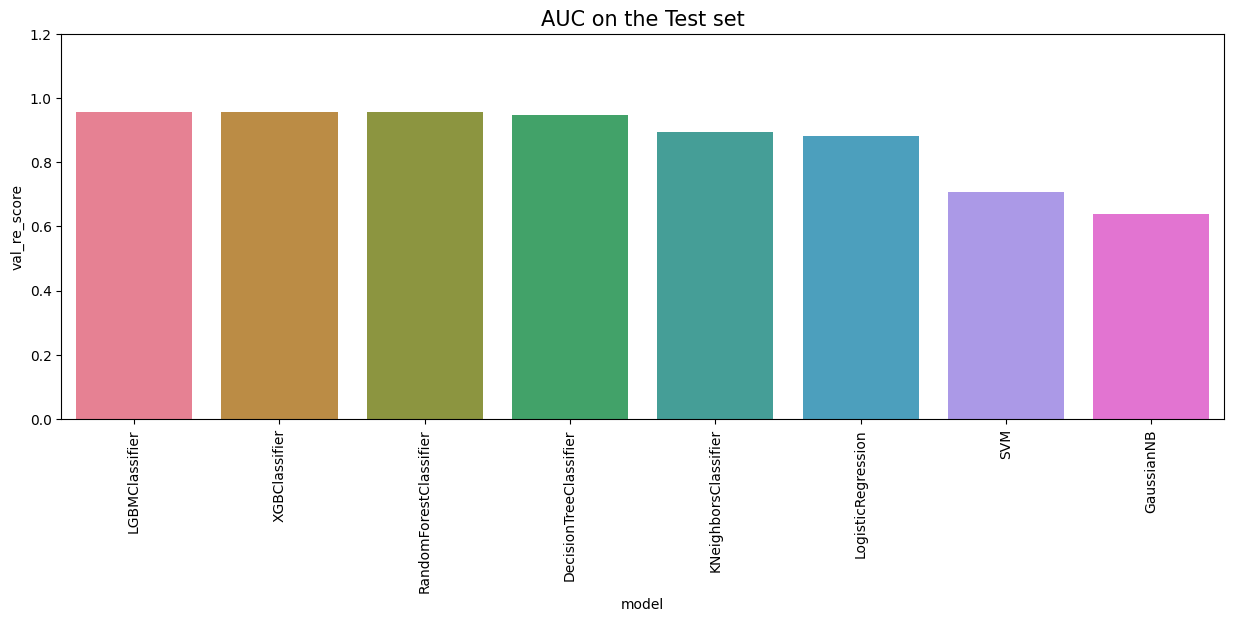

In [85]:
check_performance_for_model(df_results, version='val_re_score')

C:\Users\kim_h\AppData\Local\Temp\ipykernel_27840\526139707.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y=version, data=df_results, palette=palette)


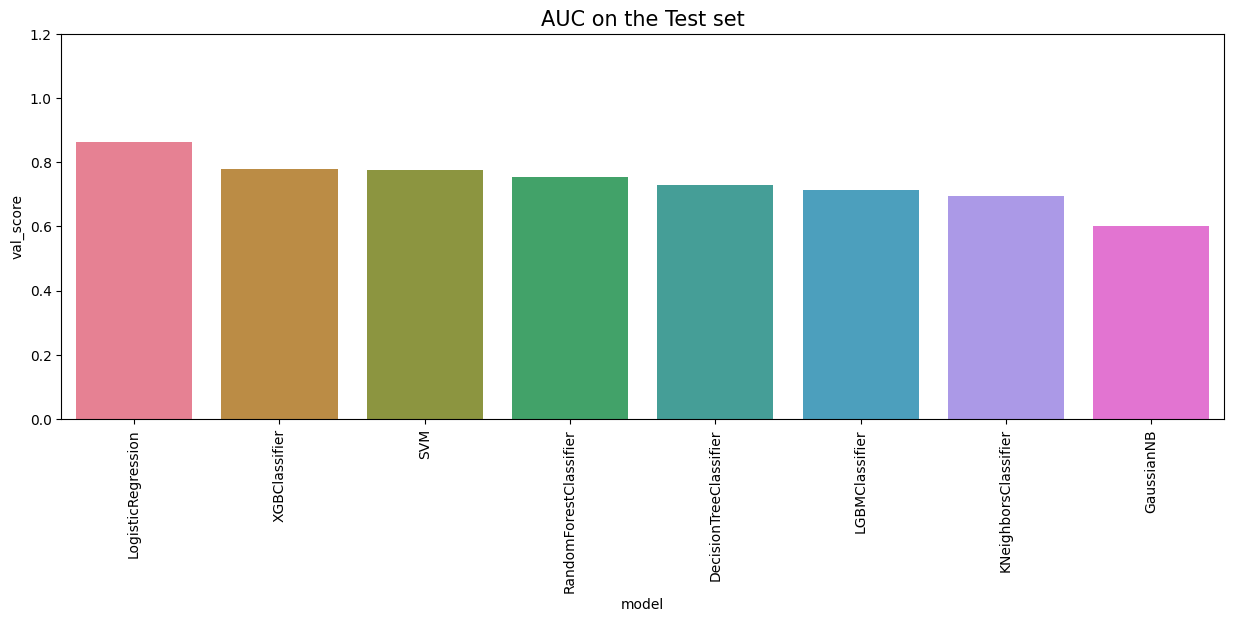

In [86]:
check_performance_for_model(df_results, version='val_score')